In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# fashion mnist dataset을 통한 딥러닝 학습 실습을 정리하기 위한 공간임

* 일반적으로 로직은
* functional api 모델 생성 후 pixel 값 조정 및 type 조정
* one hot encoding 적용
* 이후 학습 검증 테스트 데이터로 나눈다
* 마지막으로 complie, 학습/예측/평가

## 데이터 전처리 수행

* 0에서 255 사이의 픽셀값을 0에서 1 사이로 변환. 이 과정을 거쳐야 성능 향상
* array type은 float32. tensorflow도 데이터를 끌어올 떄 자동적으로 float32로 바꾼다
* 전처리를 수행하기 전에 train_labels를 보면 type이 unit8로 되어 있음

In [2]:
from tensorflow.keras.datasets import fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# 전처리를 수행하기 전 데이터들을 보면 type이 unit8임
print(type(train_images[0][0][0]))
print(train_images.shape)

2024-02-01 13:36:22.748658: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-01 13:36:22.748830: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-01 13:36:22.924094: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


4422102/4422102 [==============================] - 1s 0us/step
<class 'numpy.uint8'>
(60000, 28, 28)


In [3]:
print(test_images.shape)

(10000, 28, 28)


Text(0.5, 1.0, '9')

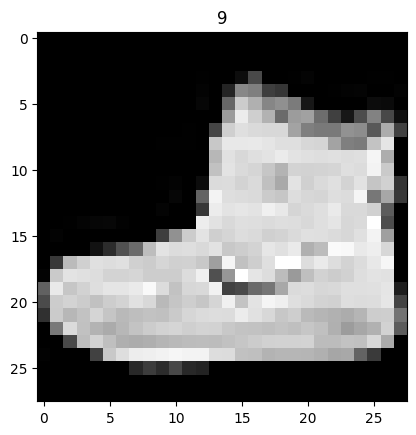

In [4]:
# fashion mnist 데이터 샘플 출력

import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(train_images[0], cmap='gray')
plt.title(train_labels[0])

In [5]:
# functional api를 이용한 model 생성

from tensorflow.keras.layers import  Layer, Input, Dense, Flatten
from tensorflow.keras.models import Model
import tensorflow as tf

INPUT_SIZE = 28

def create_model():
    input_tensor = Input(shape=(INPUT_SIZE, INPUT_SIZE))
    x = Flatten()(input_tensor)
    x = Dense(100, activation='relu')(x)
    x = Dense(30, activation='relu')(x)
    output = Dense(10, activation='softmax')(x)
    
    # functional api의 경우 multi input output을 지원하는데 sequentail은 불가능
    model = Model(inputs=input_tensor, outputs=output)
    
    return model

model = create_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 30)                3030      
                                                                 
 dense_2 (Dense)             (None, 10)                310       
                                                                 
Total params: 81840 (319.69 KB)
Trainable params: 81840 (319.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [6]:
# 데이터 전처리 함수

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# 0~1 사잇값의 float32로 전처리

def get_preprocessed_data(images, labels):
    images = np.array(images/255.0, dtype=np.float32)
    labels = np.array(labels, dtype=np.float32)
    
    return images, labels

# 0~1 사잇값 float32로 변경하는 함수 호출 후 one hot encoding 적용

def get_preprocessed_ohe(images, labels):
    images, labels = get_preprocessed_data(images, labels)
    
    # labels 데이터를 one hot encoding
    oh_labels = to_categorical(labels)
    
    return images, oh_labels

# 학습/검증/테스트 데이터 세트에 전처리 및 one hot encoding 적용
# 여기서 전처리 및 one hot encoding 과정을 거친 후 학습과 검증 데이터를 분리하면 효율적

def get_train_valid_test_split(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=42):
    
    # 학습과 테스트 데이터의 전처리 후 학습이랑 검증 데이터 분리
    train_images, train_oh_labels = get_preprocessed_ohe(train_images, train_labels)
    test_images, test_oh_labels = get_preprocessed_ohe(test_images, test_labels)
    
    # 학습과 검증 데이터 분리
    train_images, valid_images, train_oh_images, valid_oh_labels = train_test_split(train_images, train_oh_labels, test_size=valid_size, random_state=random_state)
    
    return (train_images, train_oh_images), (valid_images, valid_oh_labels), (test_images, test_oh_labels)

In [7]:
# 데이터 전처리 함수를 활용한 실제 데이터 전처리

from tensorflow.keras.datasets import fashion_mnist

# fashion mnist 데이터 재 로딩 및 전처리 적용해서 학습/검증/테스트 데이터 세트 결정
# 데이터 받아오기 / 처음 받아오는 데이터 타입은 numpy.ndarray이다

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
print(type(train_labels))

(tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels) = \
    get_train_valid_test_split(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=42)

print((tr_images.shape, tr_oh_labels.shape))  # labels를 보면 one hot encoding이 되어 있다

<class 'numpy.ndarray'>
((51000, 28, 28), (51000, 10))


# loss와 optimizer 설정을 통한 학습 수행
* loss는 categorical_crossentropy로, optimizer는 Adam으로 설정
* categorical crossentropy를 위해서 Label을 one hot encoding으로 변경(keras의 to_categorical을 통해)

In [8]:
from tensorflow.keras.optimizers import Adam

# model 생성 및 optimizer, loss, metric 적용

model = create_model()
model.summary()

# compile을 통해 loss 함수와 optimizer 설정
# one hot encoding이 되었으면 categorical, 아닌 경우 sparse categorical
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 100)               78500     
                                                                 
 dense_4 (Dense)             (None, 30)                3030      
                                                                 
 dense_5 (Dense)             (None, 10)                310       
                                                                 
Total params: 81840 (319.69 KB)
Trainable params: 81840 (319.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
# 학습 수행의 경우 model의 fit을 통해 진행
# history를 통해 결과를 받는다. loss와 accuracy metrics를 받는다
# epoch를 통해 6만개를 batch 수만큼 쪼개서 학습하는데 이걸 epoch 횟수만큼 반복

history = model.fit(x=tr_images, y=tr_oh_labels, batch_size=128, epochs=20, validation_data=(val_images, val_oh_labels))

Epoch 1/20
399/399 [==============================] - 3s 5ms/step - loss: 0.6018 - accuracy: 0.7923 - val_loss: 0.4701 - val_accuracy: 0.8350
Epoch 2/20
399/399 [==============================] - 2s 5ms/step - loss: 0.4113 - accuracy: 0.8544 - val_loss: 0.4162 - val_accuracy: 0.8491
Epoch 3/20
399/399 [==============================] - 2s 4ms/step - loss: 0.3699 - accuracy: 0.8685 - val_loss: 0.3761 - val_accuracy: 0.8646
Epoch 4/20
399/399 [==============================] - 2s 5ms/step - loss: 0.3430 - accuracy: 0.8760 - val_loss: 0.3657 - val_accuracy: 0.8711
Epoch 5/20
399/399 [==============================] - 2s 4ms/step - loss: 0.3206 - accuracy: 0.8843 - val_loss: 0.3554 - val_accuracy: 0.8691
Epoch 6/20
399/399 [==============================] - 2s 4ms/step - loss: 0.3102 - accuracy: 0.8869 - val_loss: 0.3394 - val_accuracy: 0.8792
Epoch 7/20
399/399 [==============================] - 2s 5ms/step - loss: 0.2956 - accuracy: 0.8926 - val_loss: 0.3543 - val_accuracy: 0.8713
Epoch 

In [10]:
history.history

{'loss': [0.601794421672821,
  0.41133037209510803,
  0.3698749542236328,
  0.3430267572402954,
  0.3206246495246887,
  0.31016167998313904,
  0.2955970764160156,
  0.28696930408477783,
  0.273668497800827,
  0.26539716124534607,
  0.2555334270000458,
  0.25158587098121643,
  0.24201028048992157,
  0.23805639147758484,
  0.23181156814098358,
  0.22720134258270264,
  0.2211804986000061,
  0.21666978299617767,
  0.21256013214588165,
  0.20673620700836182],
 'accuracy': [0.7922549247741699,
  0.854411780834198,
  0.8685490489006042,
  0.8760195970535278,
  0.8842744827270508,
  0.8869019746780396,
  0.8925686478614807,
  0.8943137526512146,
  0.8994901776313782,
  0.9023921489715576,
  0.9059215784072876,
  0.9073725342750549,
  0.910921573638916,
  0.9109607934951782,
  0.91354900598526,
  0.9152941107749939,
  0.9179019331932068,
  0.9191372394561768,
  0.9220196008682251,
  0.9230980277061462],
 'val_loss': [0.47010889649391174,
  0.416184663772583,
  0.3760523200035095,
  0.3656779229

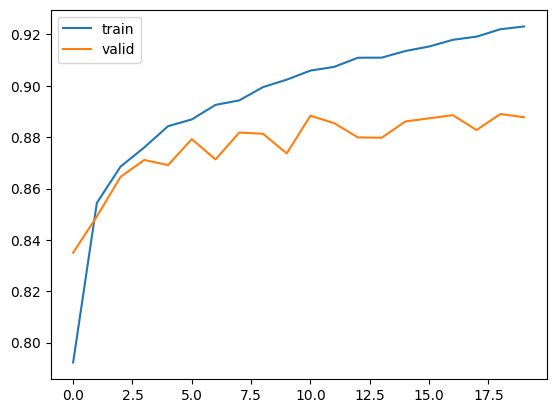

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_history(hisotry):
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
    plt.legend()
    
show_history(history)

In [12]:
# 테스트 세트로 모델 성능 검증

model.evaluate(x=test_images, y=test_oh_labels, batch_size=256, verbose=1)

40/40 [==============================] - 0s 3ms/step - loss: 0.3572 - accuracy: 0.8829


[0.35724279284477234, 0.8828999996185303]